# LMC Analysis: Part II
## Mock Observables from Models of the Large Magellanic Cloud
### Author: Chad Bustard

This notebook goes through a few analyses of simulation data, specifically the simulations published in Bustard et al. 2020 of ram pressure stripping and supernova-driven outflows from the Large Magellanic Cloud. 

#### Main publication: https://ui.adsabs.harvard.edu/abs/2020ApJ...893...29B/abstract

In part II (this notebook), we will plot values of "ram pressure" across the LMC disk and tabulate them at specific points where there are observational sightlines (this part, followed by an analysis of correlations between local ram pressure and observed ion abundances forms the basis for a funded Hubble Space Telescope (HST) grant (PI: Yong Zheng, Co-I: Chad Bustard)

## Ram Pressure
The ram pressure acting on an object moving with velocity $\bf{v_{infall}}$ through a static background gas with density $\rho$ is, in most basic form: 

(most basic) $P_{\rm ram} = \rho v_{\rm infall}^{2}$

This pressure counteracts the gravitational "tension" force of the galaxy to strip gas from the galaxy.

### Towards the *local* ram pressure in different regions of the LMC
The above equation would describe the interaction between a galaxy and a headwind *if the velocity offset between the galaxy and headwind were constant across the disk*; however, to understand how ram pressure affects local star formation rates, local ion abundances, etc. we would like a more *local* description of ram pressure.

To a first approximation, we can assume the LMC is a rotating disk infalling at an arbitrary inclination. We have to account for the fact that, from the perspective of the LMC, some parts of the disk are rotating *into* the headwind while others are rotating *away* from the headwind. Therefore, the velocity vector of interest is really $v_{\rm infall} - v_{\rm rot}$, where $v_{\rm rot}(x_{\rm LMC}, y_{\rm LMC}) = (v_{\rm rot,x}, v_{\rm rot,y})$ is the rotation vector (in coordinates such that $\hat{z}$ is along the axis of disk rotation, and $v_{\rm infall} = (v_{x}, v_{y}, v_{z})$ is the infall velocity vector of the LMC "as a whole" motivated by observations and more complete simulations of the LMC's interaction (including it's complicated gravitational dance with it's neighboring SMC): 

(including rotation) ${\bf P}_{\rm ram}(x_{LMC}, y_{LMC}) = \rho \left((v_{x}-v_{rot,x})^{2}\hat{x} + (v_{y}-v_{rot,y})^{2}\hat{y} + v_{z}^{2}\hat{z}\right)$. 

Note that we've written the ram pressure as a vector and with dependence on LMC-centered coordinates $(x_{LMC}, y_{LMC})$ in the plane perpendicular to the disk axis of rotation. So to know the ram pressure impacting any point $(x_{LMC}, y_{LMC})$ across the disk, we need the following ingredients:

    1. The density of the Milky Way halo at the current LMC location. 
    
    2. The infall velocity vector -- really, a combination of the LMC's infall velocity and a sense of it's inclination during infall (you can imagine a disk "slicing" through the air vs a disk "pancaking" through the air).
    
    3. The rotation vector
    
In our paper, we more fully account for how, over the course of its infall, the LMC changes both its distance from the Milky Way (and therefore the increasing halo gas density it interacts with as it gets closer and closer to the Milky Way) and its inclination. 

It's not worth going into all the observational measurements that lead to estimates of the halo gas density, the infall velocity, etc. Just know that $\rho$, $v_{x}$, $v_{y}$, $v_{z}$ are well-motivated but, of course, have some uncertainties.

The rotation velocity can be calculated by assuming hydrostatic balance between the LMC's centrifugal force and gravitational force...that's how it is done in the Fortran-based FLASH simulations I created to model the LMC...but in the next cell, we'll just take the rotation velocity as a function of $r_{LMC}$ from Salem et al. 2015. 

An additional complexity we can account for is that galaxies are constantly expelling and accreting gas through the *disk-halo interface*, here the region between the LMC's disk and its surrounding *circumgalactic medium.* These gas flows are "very" challenging to model correctly (no model is ever correct, some are just closer to reality), but my own simulations (Bustard et al. 2020) are a first-of-their-kind attempt to model the supernova-driven galactic outflows from the LMC, connecting them to the temporally and spatially resolved star formation history that ultimately determines the time and locations of galactic outflow driving. Check out the .F90 file in this directory for the initial condition and boundary condition code (the FLASH code this is built on is proprietary, so that's all I can post on Github).

Generalizing $v_{\rm rot}$ to $v_{\rm local} = (v_{loc,x},v_{loc,y},v_{loc,z})$, which includes all velocity information relative to the frame of rest of the LMC, the full ram pressure can be estimated as 

(including local gas flows) ${\bf P}_{\rm ram}(x_{LMC}, y_{LMC}, z_{LMC}) = \rho \left((v_{x}-v_{loc,x})^{2}\hat{x} + (v_{y}-v_{loc,y})^{2}\hat{y} + (v_{z} - v_{loc,z})^{2}\hat{z}\right)$

Note that, while rotation doesn't alter ram pressure in the $\hat{z}$ direction, other gas flows surely can and could be included here. 

In [1]:
# Import all the packages we need
import yt
import trident
from trident import LightRay
import aplpy
import numpy as np
#import matplotlib as plt
from yt.units.yt_array import YTQuantity
from yt import YTArray
import h5py
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy import wcs
from astropy.wcs import WCS
import csv
import pandas as pd

!pip install cmasher # a nice repository of colorblind-friendly, aesthetically pleasing colormaps
import cmasher as cmr

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [20]:
# Get the HDF5 file and additional CSV files from Google Drive link
!pip install --upgrade --no-cache-dir gdown
import gdown

gdown.download_folder("https://drive.google.com/drive/folders/1cctLEApfIzfdfa0RpisgtKnJzfck4uJK")

Requirement already up-to-date: gdown in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (4.7.1)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


Retrieving folder list


Processing file 1CD7SLWtpcCW6QZiSvv8AS82auvZAdvZt aligned_LMC_SFR_RP_rotation_ChadVersion.csv
Processing file 13-BB9KNw6GKtKcJbURRa37SLuzQHwqIk ullyses_lmc_dr5_chadedits.csv
Processing file 1BCvIdYOA3VZj91Fdh9seOki0ww3Rqiky windCRs_hdf5_plt_cnt_0050
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1CD7SLWtpcCW6QZiSvv8AS82auvZAdvZt
To: /Users/chad/Desktop/research_overview/research_overview/LMC_Analysis_Examples/LMC_high_mass/aligned_LMC_SFR_RP_rotation_ChadVersion.csv
100%|██████████| 4.21k/4.21k [00:00<00:00, 3.32MB/s]
Downloading...
From: https://drive.google.com/uc?id=13-BB9KNw6GKtKcJbURRa37SLuzQHwqIk
To: /Users/chad/Desktop/research_overview/research_overview/LMC_Analysis_Examples/LMC_high_mass/ullyses_lmc_dr5_chadedits.csv
100%|██████████| 2.09k/2.09k [00:00<00:00, 2.33MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1BCvIdYOA3VZj91Fdh9seOki0ww3Rqiky
From (redirected): https://drive.google.com/uc?id=1BCvIdYOA3VZj91Fdh9seOki0ww3Rqiky&confirm=t&uuid=f1ff1b5a-b49f-432d-8a2b-fc9594d2c8f0
To: /Users/chad/Desktop/research_overview/research_overview/LMC_Analysis_Examples/LMC_high_mass/windCRs_hdf5_plt_cnt_0050
100%|██████████| 668M/668M [00:21<00:00

['/Users/chad/Desktop/research_overview/research_overview/LMC_Analysis_Examples/LMC_high_mass/aligned_LMC_SFR_RP_rotation_ChadVersion.csv',
 '/Users/chad/Desktop/research_overview/research_overview/LMC_Analysis_Examples/LMC_high_mass/ullyses_lmc_dr5_chadedits.csv',
 '/Users/chad/Desktop/research_overview/research_overview/LMC_Analysis_Examples/LMC_high_mass/windCRs_hdf5_plt_cnt_0050']

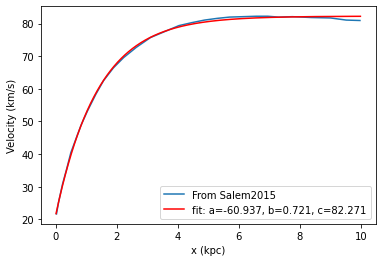

In [3]:
# Rotation velocity from Salem+ 2015
# In the form I obtained it, the velocity is tabulated as a function of cylindrical radius (zero radius is the center of the LMC)

# Let's use scipy to fit an exponential curve to our data 
from scipy.optimize import curve_fit
 
def func(x,a,b,c):
    return a * np.exp(-b * x) + c

# radius in units of kiloparsecs (kpc)
r_data = [0.025,0.091,0.223,0.364,0.496,0.709,0.84,1.043,1.316,1.569,1.893,2.227,2.642,3.107,3.573,4.038,4.464,4.879,5.294,5.698,6.144,6.579,6.953,7.308,7.763,8.381,9.008,9.524, 9.975]

# rotational velocity
v_data = [21.671,25.196,30.809,35.64,40.47,45.822,49.086,53.264,58.355,62.533,66.449,69.582,72.715,75.718,77.546,79.373,80.287,81.07,81.593,81.984,82.115,82.245,82.245,81.984,  82.115,81.854,81.723,81.07,80.94]


r_arr = np.arange(0.01,10,0.01)
popt, pcov = curve_fit(func, r_data, v_data)
#print(popt)
plt.plot(r_data,v_data,label="From Salem2015")
plt.plot(r_arr, func(r_arr, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel("x (kpc)")
plt.ylabel("Velocity (km/s)")
plt.legend()
plt.show()


This curve with appropriate values for a, b, c fits the data extremely well (that functional form is physically motivated, so I knew it would work well), so let's take the magnitude of the velocity to be $v(r) = a e^{-br} + c$ from now on and proceed to calculate the ram pressure.

For the remainder of this notebook, we employ the `yt` package, a visualization and analysis toolkit for astrophysics: https://yt-project.org/. We first create a new function for the "most basic" ram pressure given the "headwind" $v_{\rm infall}$, and then the next order ram pressure that also takes into account the disk rotation $v_{\rm rot}$ into/away from the headwind. 

In [4]:
# define new functions for ram pressure

def _ramPres_norot(field, data): # ram pressure #1, NOT including rotation effect or local gas flows
        # density of the Milky Way halo at present-day position of LMC is rho = 1.65e-28 g/cm^3
        # v_infall = (220, 159, 192) km/s
        val = 1.65e-28*YTQuantity(1,'g/cm**3')*((220.0*1e5*data['ones']*YTQuantity(1,'cm/s'))**2.0 + (159.0*1e5*data['ones']*YTQuantity(1,'cm/s'))**2.0 + (192.0*1e5*data['ones']*YTQuantity(1,'cm/s'))**2.0)
        return val

yt.add_field(("gas","ramPres_norot"), function=_ramPres_norot, sampling_type='local',units="dyne/cm**2")


def _ramPres_rot(field, data): # ram pressure #2, including rotation effect but not local gas flows
        rad = np.sqrt((data['x']**2.0 + data['y']**2.0)) # radius from center of LMC
        velrot_y = 1.e5*func(rad,*popt)*data['x']/rad*YTQuantity(1,'cm/s') # v_y in units of km/s
        velrot_x = 1.e5*func(rad,*popt)*data['y']/rad*YTQuantity(1,'cm/s') # v_x
        
        # density of the Milky Way halo at present-day position of LMC is rho = 1.65e-28 g/cm^3
        # v_infall = (220, 159, 192) km/s
        val = 1.65e-28*YTQuantity(1,'g/cm**3')*((220.0*1e5*data['ones']*YTQuantity(1,'cm/s') - velrot_x)**2.0 + (159.0*1e5*data['ones']*YTQuantity(1,'cm/s') - velrot_y)**2.0 + (192.0*1e5*data['ones']*YTQuantity(1,'cm/s'))**2.0)
        return val

yt.add_field(("gas","ramPres_rot"), function=_ramPres_rot, sampling_type='local',units="dyne/cm**2")
 
 

In [21]:
# load in the dataset and set line of sight vector L
ds = yt.load("LMC_high_mass/windCRs_hdf5_plt_cnt_0050")
dd = ds.all_data()

L = [-0.561,0.099,0.822] # vector normal to cutting plane
north_vector = [0,0,1]

sky_center = [79.0,-68.68] # in degrees
sky_scale = (4123.71, "arcsec/kpc") # could also use a YTQuantity

# Restrict our plot to just the galaxy (cells with an ISM tag > 0.6)
cut_data = dd.cut_region('(obj["ism "] > 0.6)')

# Make plots along the line of sight and save as FITS files for future access
prj_fits = yt.FITSOffAxisProjection(ds,L,'ramPres_norot',center = (0,0,0),width=(20, 'kpc'), weight_field="ones",data_source=cut_data)
prj_fits.create_sky_wcs(sky_center, sky_scale, ctype=["RA---TAN","DEC--TAN"], replace_old_wcs=True)
prj_fits.writeto("LMC_ram_RP_norotate.fits", overwrite=True)

prj_fits = yt.FITSOffAxisProjection(ds,L,'ramPres_rot',center = (0,0,0),width=(20, 'kpc'), weight_field="ones",data_source=cut_data)
sky_center = [79.0,-68.68] # in degrees
sky_scale = (4123.71, "arcsec/kpc") # could also use a YTQuantity
prj_fits.create_sky_wcs(sky_center, sky_scale, ctype=["RA---TAN","DEC--TAN"], replace_old_wcs=True)
prj_fits.writeto("LMC_ram_RP_rotate.fits", overwrite=True)

yt : [INFO     ] 2023-05-08 22:06:39,187 Parameters: current_time              = 3.156010944496386e+16
yt : [INFO     ] 2023-05-08 22:06:39,190 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2023-05-08 22:06:39,193 Parameters: domain_left_edge          = [-6.171e+22 -6.171e+22 -6.171e+22]
yt : [INFO     ] 2023-05-08 22:06:39,195 Parameters: domain_right_edge         = [1.234e+23 1.234e+23 1.234e+23]
yt : [INFO     ] 2023-05-08 22:06:39,196 Parameters: cosmological_simulation   = 0
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/unyt/array.py:1882: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
yt : [INFO     ] 2023-05-08 22:07:31,733 Making a FITS image of field ramPres_norot
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/unyt/array.py:1882: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
yt : [INFO     ] 2023-05-08 22:08:45,563 Making a FITS image of field ram

image type: <class 'numpy.ndarray'>
shape of image: (512, 512)


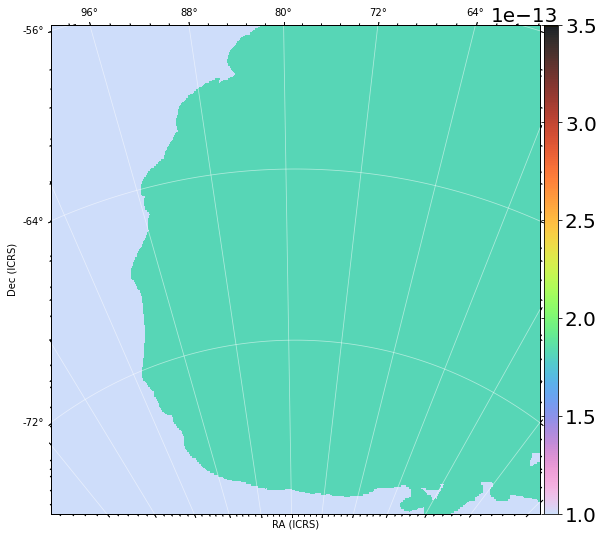

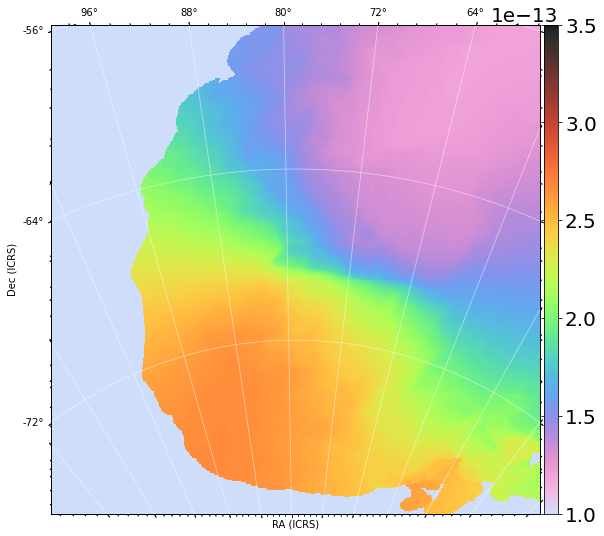

In [22]:
image_data_norot = fits.getdata('LMC_ram_RP_norotate.fits')
image_data_rot = fits.getdata('LMC_ram_RP_rotate.fits')
print("image type: " + str(type(image_data_rot)))
print("shape of image: " +str(image_data_rot.shape))

# create a quick plotting function we can use again
def plot_fits(fits_file):
    fig = aplpy.FITSFigure(fits_file)
    fig.add_grid()
    fig.show_colorscale(cmap="kamae_r",stretch = 'linear', vmin=1E-13, vmax = 3.5E-13)
    fig.tick_labels.set_xposition("top")
    fig.ticks.set_xspacing(8.0)
    fig.ticks.set_yspacing(8.0)
    fig.add_colorbar()
 
    # fig.tick_labels.set_xformat('hh:mm')
    fig.tick_labels.set_xformat('dd')
    fig.tick_labels.set_yformat('dd')
    # fig.set_theme('pretty')
    fig.colorbar.show(log_format=False)
    fig.colorbar.set_font(size=20)
    #fig.show()

# plot ram pressure with and without rotation
plot_fits("LMC_ram_RP_norotate.fits")
plot_fits("LMC_ram_RP_rotate.fits")

The top panel, not accounting for rotation, obviously shows a constant ram pressure across the whole disk since there is no dependence on position. The bottom panel, however, reflects that the true ram pressure is highest in the lower left corner where the disk is rotating into the headwind. Let's overlay some observational sightlines and tabulate ram pressure for each sightline.

## Reading in sightlines

We read in sightlines from a pre-made CSV file that provides RA, DEC coordinates for each one

In [30]:
# Read in table of (RA, DEC) values for sightlines through the LMC
inputArr = np.genfromtxt('LMC_high_mass/ullyses_lmc_dr5_chadedits.csv',delimiter=',',invalid_raise=False)
ra_data = inputArr[:,0]
ra_data = ra_data[1:len(ra_data)]
dec_data = inputArr[:,1]
dec_data = dec_data[1:len(dec_data)]

Let's take a quick look at the file header for the ram pressure FITS file we created. It shows the "World Coordinate System (WCS)" keywords, including the type of axes we are using (RA--TAN and DEC--TAN) and the number of points along each axis (512 x 512)

In [31]:
f = fits.open("LMC_ram_RP_rotate.fits")
w = wcs.WCS(f[0].header)
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 79.0  -68.68  
CRPIX : 256.5  256.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0447451171875  0.0447451171875  
NAXIS : 512  512


We'll make use of Astropy's built-in transformations to map from world coordinates to pixel coordinates. That way we can figure out where each sightline, given to us in world coordinates, lies on our simulation grid: https://python4astronomers.github.io/astropy/wcs.html

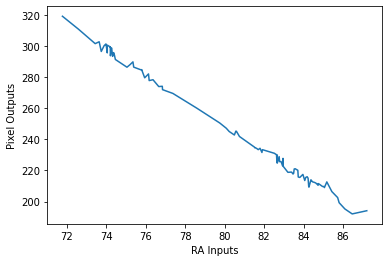

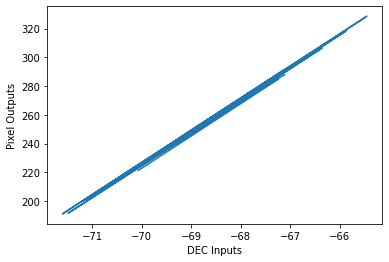

In [33]:
# convert from world to pixel coords
ra_test, dec_test = w.wcs_world2pix(ra_data, dec_data, 1)

# Make some quick plots 
plt.plot(ra_data,ra_test)
plt.xlabel("RA Inputs")
plt.ylabel("Pixel Outputs")
plt.show()

plt.plot(dec_data,dec_test)
plt.xlabel("DEC Inputs")
plt.ylabel("Pixel Outputs")
plt.show()

In [34]:
# access the ram pressure values from ramPres_rot file
ram_arr = f["ramPres_rot"].data

rp_pixel_coords = []
for j in range(0,len(ra_data)):
    ra, dec = w.wcs_world2pix(ra_data[j], dec_data[j], 1)
    
    # 
    ra = int(ra)
    dec = int(dec)
    rp_pixel_coords.append(ram_arr[dec,ra])

     RA(deg)  Dec(deg)  Unnamed: 2  RP(dyne/cm^2)
0    71.7686  -67.1148         NaN   1.402618e-13
1    72.5789  -67.6606         NaN   1.505098e-13
2    73.4304  -68.7148         NaN   1.813268e-13
3    73.6329  -67.2568         NaN   1.490383e-13
4    73.7390  -70.0412         NaN   2.281196e-13
..       ...       ...         ...            ...
105  85.7289  -68.9485         NaN   2.372947e-13
106  85.8042  -67.8544         NaN   2.204783e-13
107  86.0963  -67.2414         NaN   2.106828e-13
108  86.4664  -67.2405         NaN   2.117671e-13
109  87.2069  -70.0661         NaN   2.493760e-13

[110 rows x 4 columns]


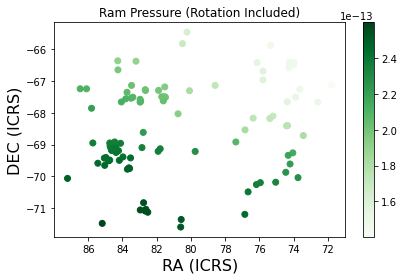

In [35]:
# Open the CSV file using Pandas, call it df
df = pd.read_csv('LMC_high_mass/ullyses_lmc_dr5_chadedits.csv')

# Add a column for RP -- units are dyne/cm^2
df['RP(dyne/cm^2)'] = rp_pixel_coords

# Print the new dataframe df
print(df)
 
# Plot the sightlines in RA, DEC coordinates, with color = ram pressure magnitude    
sc = plt.scatter(ra_data,dec_data, c = rp_pixel_coords,cmap="Greens")
plt.colorbar(sc)
plt.title("Ram Pressure (Rotation Included)")
plt.gca().invert_xaxis()
plt.xlabel("RA (ICRS)",fontsize=16)
plt.ylabel("DEC (ICRS)",fontsize=16)
plt.tight_layout()
plt.show()
 
# Write df (with appended column for RP values) to a new CSV file 
df.to_csv('RP_Rotation_dr5_Sept2022.csv')

# Quick analysis of ram pressure vs star formation rate
A question of interest: does ram pressure correlate with star formation rate? We hypothesize that higher ram pressure causes more gas compression, leading to gravitational instability and gas collapse, eventually forming stars. With a birds-eye view of star formation in the LMC, combined with ram pressure values taken from these simulations, do we find a correlation?

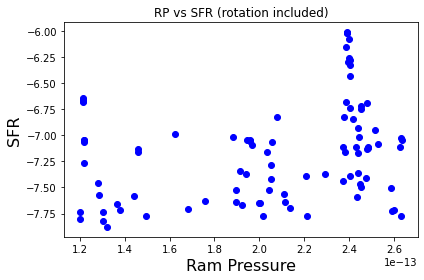

In [37]:
inputArr = np.genfromtxt('LMC_high_mass/aligned_LMC_SFR_RP_rotation_ChadVersion.csv',delimiter=',', invalid_raise=False)
SFR = inputArr[:,0]
SFR = SFR[1:len(SFR)]
ra = inputArr[:,1]
ra = ra[1:len(ra)]
dec = inputArr[:,2]
dec = dec[1:len(dec)]
RP = inputArr[:,3]
RP = RP[1:len(RP)]

plt.plot(RP, SFR,'bo')
plt.title("RP vs SFR (rotation included)")
plt.xlabel("Ram Pressure",fontsize=16)
plt.ylabel("SFR",fontsize=16)
plt.tight_layout()
plt.savefig("SFR_RP_wholeDisk.pdf")
plt.show()
plt.close()

Across *all* sightlines sampling the entire LMC disk, there's only a slight correlation. One route towards further insights would be to separate the data into different quadrants depending on LMC position. But the sampling is clearly not spatially uniform...we're really interested in what the mean star formation rate is in different regions, as well as the variance in those regions. To that end, we can coarse-grain our data and look for correlations.

Testing mask to show only SFRs inside a certain region: 
[-7.71 -7.16 -7.04 -7.04 -7.52 -7.05 -7.05 -7.34 -7.09 -7.47 -7.67 -7.5
 -7.65 -7.65 -7.37 -7.39 -7.28 -7.06 -7.52 -7.64 -7.42 -7.77 -7.36 -7.12
 -7.13 -7.11 -6.82 -7.11 -7.56 -7.16 -7.17 -6.74 -7.37 -6.84 -6.3  -6.68
 -6.26 -7.11 -6.28 -6.08 -6.43 -6.33 -6.01 -6.02 -6.02 -6.15 -6.82 -6.75
 -6.72 -6.93 -6.69 -7.02 -7.41 -7.44 -7.39 -7.64 -7.7 ]
SFR averages: 
[0, -6.804233570533134, -7.453491512184222, -7.718155183284904, -7.6920671165286745, -7.2168688857093, -7.107898374506615, -7.547369968505555, -7.231256155907228, -6.5215524045230815, 0, 0, 0, 0, 0, 0]


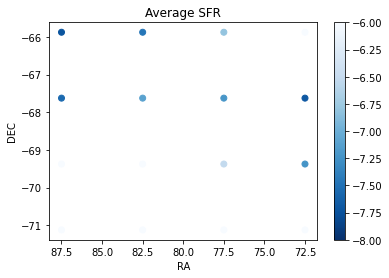

In [40]:
import warnings

# dec range is -65 to -72
# ra range is 70 to 90

print("Testing mask to show only SFRs inside a certain region: ")
test = np.where((dec > -70) & (dec < -64) & (ra < 90) & (ra > 80))
print(SFR[test])

# Can play around here with different numbers of bins (numbin) and RA, DEC ranges
numbin = 4
ra_min, ra_max = 70, 90
dec_min, dec_max = -72, -65

raGrid = np.arange(ra_min,ra_max,((ra_max-ra_min)/numbin))
decGrid = np.arange(dec_max,dec_min,((dec_min-dec_max)/numbin))

# populate new arrays SFR_new and RP_new with average SFR, RP in coarse-grained bins
# TODO: Calculate variances and add them to figure also
SFR_new = [0 for k in range(len(raGrid)*len(decGrid))]
RP_new = [0 for k in range(len(raGrid)*len(decGrid))]
counter = 0
for i in range(0,len(raGrid)-1):
    for j in range(0,len(decGrid)-1):
        counter +=1
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            location = np.where((dec < decGrid[j]) & (dec > decGrid[j+1]) & (ra < raGrid[i+1]) &   (ra > raGrid[i]))
            avgSFR = np.mean(10**(SFR[location]))
            avgRP = np.mean(RP[location])
            if (avgSFR > 0):
                SFR_new[counter] = np.log10(avgSFR)
                RP_new[counter] = np.log10(avgRP)
                
print("SFR averages: ")
print(SFR_new)

xnew = raGrid + ((ra_max-ra_min)/numbin)/2
ynew = decGrid +((dec_min-dec_max)/numbin)/2

x,y = np.meshgrid(xnew, ynew)

# Scatter plot of SFR averages, color is log10(RP)
plt.scatter(x,y, c = SFR_new,cmap='Blues_r',vmin = -8.0, vmax = -6)
plt.gca().invert_xaxis()
plt.xlabel("RA")
plt.ylabel("DEC")
plt.colorbar()
plt.title(r"Average SFR")
plt.savefig("AverageSFR_coarseRes.pdf")
plt.show()
plt.close()

These figures aren't too illuminating either, but there is clearly some spatial variation of SFR, on average, that could correlate with ram pressure. However, ram pressure variation *overall* is quite low -- less than a dex -- probably reflecting the limitation of our ram pressure calculation so far: we haven't included any varying contribution from gas flows above and below the disk. Indeed, since the LMC is "pancaking" during infall through the Milky Way halo, the dominant ram pressure component is vertical, and in Bustard et al. 2020, we found a clear "shielding" effect where galactic fountains are cut down by a significant headwind on the near side of the LMC disk but can flow almost unimpeded on the far side of the disk. 

## Ram pressure variations in the $\hat{z}$ direction